In [1]:
#import and download image using tensorflow
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
#Specift directory, 
dataset = tf.keras.preprocessing.image_dataset_from_directory("Plantvillage", shuffle=True, image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names


['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
len(dataset)
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1]


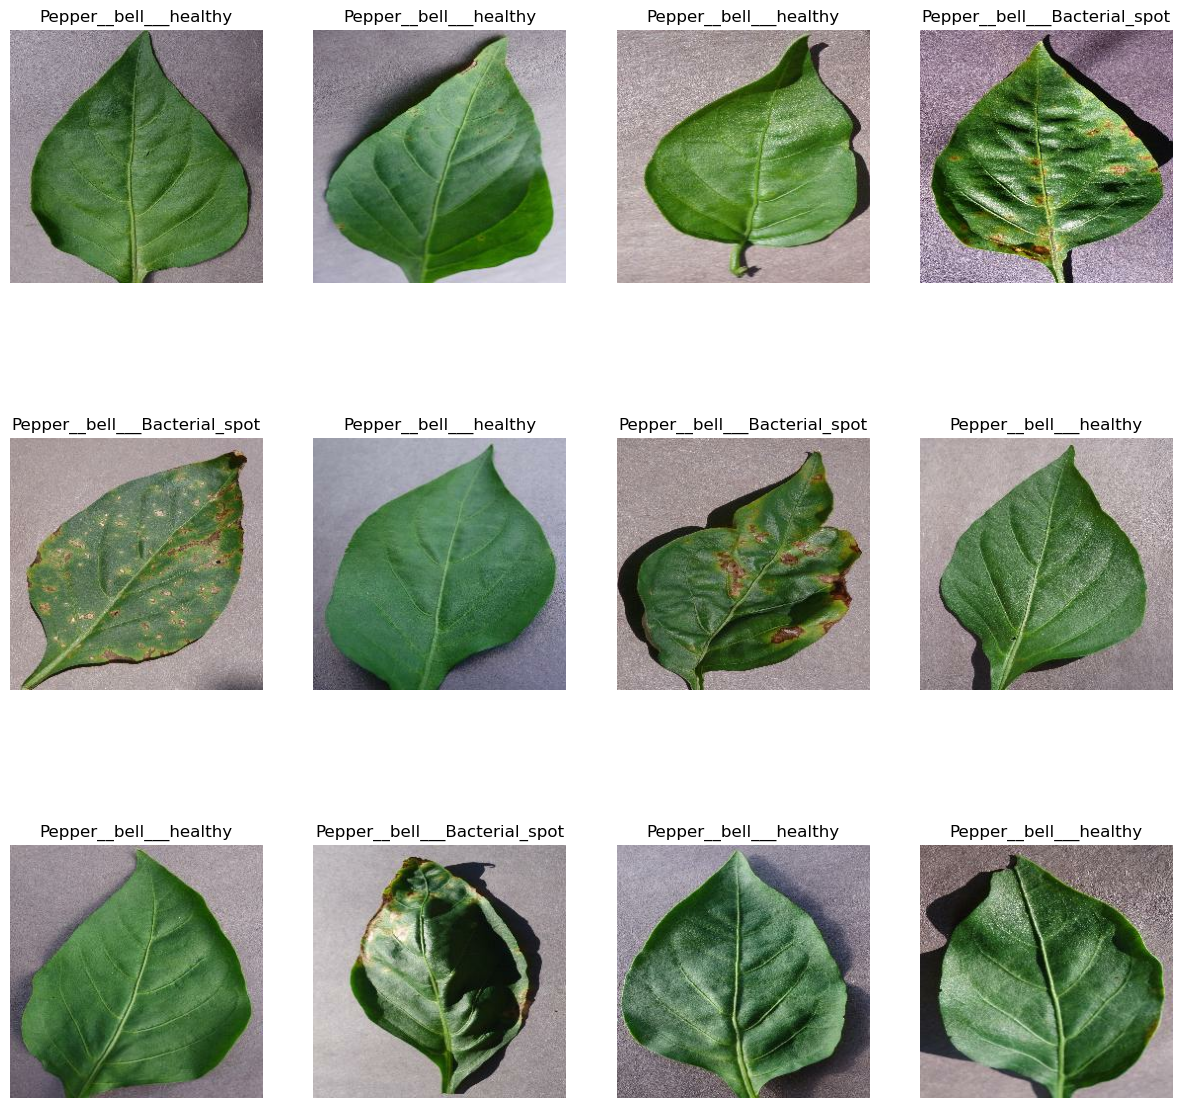

In [6]:
#VISUALIZE THIS IMAGE(Note: It won't bring the same images as they are shuffled)
#increase the area of the image to 15*15
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    #lets display 12 images
    for i in range(12):
    #you need a subplot for a matrix in 3*4
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    #how do i display the image and the label
        plt.title(class_names[label_batch[i]])
        #remove the axis numbers
        plt.axis('off')

In [7]:
len(dataset)

78

In [8]:
#Now, we will train 80% of our data. 10% validation and 10% test
#number of epochs is how many times the algorithm is going to run.

#80% ==> training
#20% ==> 10% validation, 10% test

train_size = 0.8
len(dataset)*train_size  #80% of 78 is 62.4 batches

62.400000000000006

In [9]:
train_ds = dataset.take(62)
len(train_ds)

62

In [10]:
test_ds = dataset.skip(62)
len(test_ds)

16

In [11]:
val_size = 0.1
len(dataset)*val_size

7.800000000000001

In [12]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [13]:
test_ds = test_ds.skip(7)
len(test_ds)

9

In [14]:
#Write a nice python function that will summarize everything we just wrote
def get_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_tf(dataset)

In [16]:
len(train_ds)

62

In [17]:
len(val_ds)

7

In [18]:
len(test_ds)

9

In [19]:
#Cache will read the image, and store it in memory... and then improve the performance of our pipleline
#prefetch: if GPU is busy training, the pre-patch will load the next set of batch from our disk
#lets just let tensorflow determine how many batches to load while GPU is training

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
#Time to do some pre-porcessing, the first thing is to scale
#if the make isn't 256*256, this will takecare of it :)

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [21]:
#data augmentation layer in order to avoid overfitting and make it robust
#if someone gives a rotated image, this model will predict it using  CNN
#with a seed you make sure that you can reproduce your results when using random generators
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
#CNN

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)



In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
#Optimizer

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
62/62 [==============================] - 125s 2s/step - loss: 0.8207 - accuracy: 0.7275 - val_loss: 0.4214 - val_accuracy: 0.8036
Epoch 2/10
62/62 [==============================] - 100s 2s/step - loss: 0.2801 - accuracy: 0.8864 - val_loss: 0.2967 - val_accuracy: 0.8571
Epoch 3/10
62/62 [==============================] - 98s 2s/step - loss: 0.1564 - accuracy: 0.9450 - val_loss: 0.0751 - val_accuracy: 0.9821
Epoch 4/10
62/62 [==============================] - 102s 2s/step - loss: 0.0986 - accuracy: 0.9720 - val_loss: 0.1280 - val_accuracy: 0.9464
Epoch 5/10
62/62 [==============================] - 103s 2s/step - loss: 0.0792 - accuracy: 0.9761 - val_loss: 0.0914 - val_accuracy: 0.9643
Epoch 6/10
62/62 [==============================] - 98s 2s/step - loss: 0.0752 - accuracy: 0.9791 - val_loss: 0.0235 - val_accuracy: 0.9911
Epoch 7/10
62/62 [==============================] - 96s 2s/step - loss: 0.0789 - accuracy: 0.9791 - val_loss: 0.0243 - val_accuracy: 0.9955
Epoch 8/10
62/62

In [26]:
#run a test on the dataset
scores = model.evaluate(test_ds)

9/9 [==============================] - 9s 499ms/step - loss: 0.0155 - accuracy: 0.9896


In [27]:
scores


[0.015520069748163223, 0.9895833134651184]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 62}

In [30]:
#plot this in a nice matplotlib for the accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

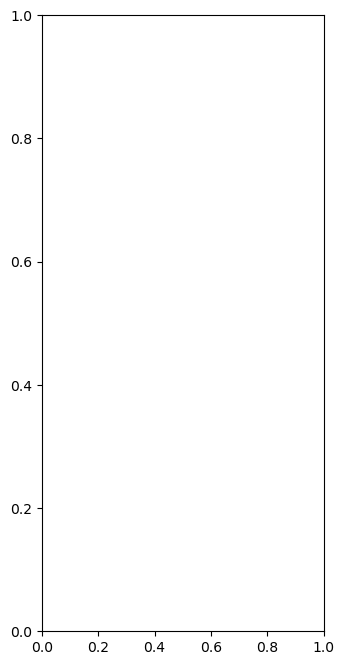

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Pepper__bell___Bacterial_spot
1/1 [==============================] - 1s 940ms/step
predicted label: Pepper__bell___Bacterial_spot


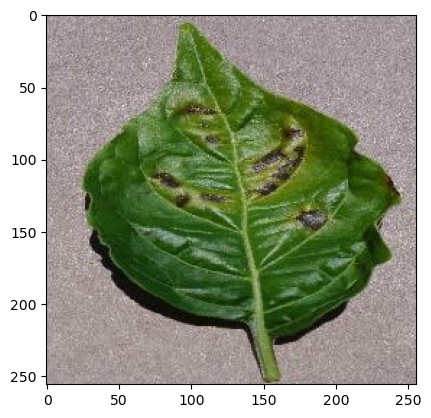

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 49ms/step


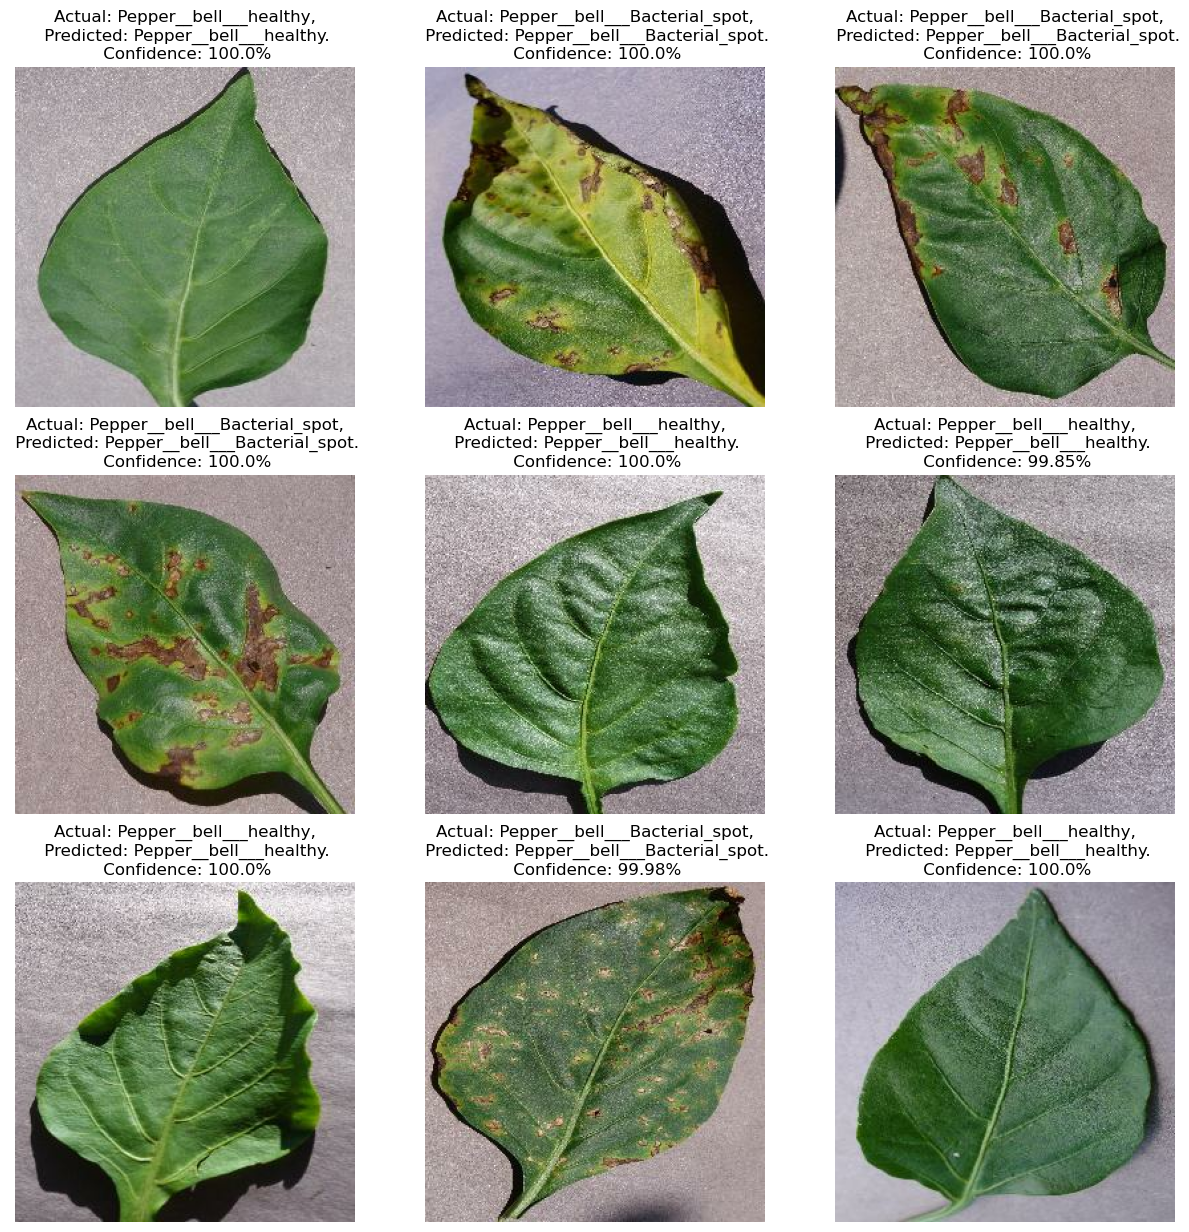

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [38]:
model.save("../pepper.h5")